## Evolution of a scalar wave equation in 1D

$$\dfrac{d\phi}{dt} = l$$

$$\dfrac{dl}{dt} = c^{2} \dfrac{d^2\phi}{dx^2}$$

With initial conditions:

$$ \phi(x,t) = \phi(x,0) = exp(-x^2 / \sigma^2) $$

$$ \dfrac{d \phi}{dt} (x,0) = l(x,0) = 0 $$

and boundary conditions:

$$ \phi(x,t) = \phi(x + L,t), -1 \leq x \leq 1 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#Physics
x_start = -1.0
x_end = +1.0
t_start = 0
t_end = 2.0
wave_speed = 1
phi_left_boundary, phi_right_boundary = 0, 0
l_left_boundary,  l_right_boundary = 0, 0

In [3]:
Nx = 401 #+1 to include 0 as a point
Nghost = 2
#CFL condition: dt < alpha*dx/c
Courant_factor = 0.1

In [4]:
def compute_dt(cf,dx,c):
    dt = (cf*dx)/c
    return dt

In [5]:
dx = (x_end - x_start)/(Nx - 1)
var_x = np.arange(x_start,x_end + dx,dx)
dt = compute_dt(Courant_factor,dx,wave_speed)
var_t = np.arange(t_start,t_end + dt,dt)
Nt = len(var_t)

In [6]:
def second_derivative(var,dx):
    D2_var = np.zeros(Nx)
    var_with_ghosts = compute_exterior_points(var)
    for i in range (1,len(var_with_ghosts)-1):
        # Central finite difference method:
        D2_var[i-1] = (var_with_ghosts[i-1] - 2*var_with_ghosts[i] + var_with_ghosts[i+1])/dx**2
    return D2_var

def compute_exterior_points(var):
    var_left_ghost = np.append(var[len(var)-1],var)
    var_ghosts = np.append(var_left_ghost,var[0])
    return var_ghosts

In [7]:
def RK2(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    u_np1 = u_n + dt*k2
    return u_np1

In [8]:
def Evolve(init,rhs,Nt,dt):
    u_0 = init()
    u_result = np.zeros((len(var_t),len(u_0),Nx)) #u_result[i][j][k]; i -> time, j-> variable, k-> x position
    print("Total iteration = %d"%(len(var_t)))
    start_time = time.time()
    u_result[0] = np.array((u_0))
    for i in range (1,Nt):
        u_np1 = np.array(RK2(rhs,u_0,dt))
        #store result of iteration
        u_result[i] = u_np1
        #update values
        u_0 = u_np1
    end_time = time.time()
    comp_time = end_time - start_time
    print("Computation time: %f seconds"%(comp_time))
    return u_result

In [9]:
#RHS expressions
def scalar_wave_RHS(u_n,dx):
    phi = u_n[0]
    l = u_n[1]
    phi_dot = l
    del_square_phi = second_derivative(phi,dx) #(variable,dx,degree of polynomial extrapolation)
    l_dot = (wave_speed**2)*del_square_phi    
    u_rhs = np.array((phi_dot,l_dot))
    return u_rhs

In [10]:
def initial_conditions(expr_phi,expr_l,dx):
    var_phi = expr_phi(var_x)
    var_l = expr_l(var_x)
    return var_phi,var_l

In [11]:
# Initial condition for phi at t=0
sigma = 0.1
expr_phi = lambda x: np.exp(-(x/sigma)**2)
#Initial condition for d/dt(phi) = l at t=0
expr_l = lambda x: 0*x

In [12]:
#Evolve variables in time
u_result = Evolve(lambda: initial_conditions(expr_phi,expr_l,dx),
                  lambda u_n: scalar_wave_RHS(u_n,dx),
                 Nt,dt)

Total iteration = 4002
Computation time: 3.862155 seconds


In [21]:
#----------- End of numerical solution computation-----------------#

In [14]:
# # Save result of computation -> Optional

#np.save("u_result,Nx=%d,t=(%0.1f,%0.1f),x=(%0.1f,%0.1f)"%(Nx,t_start,t_end,x_start,x_end),u_result)

In [15]:
# Analysis & Plotting

phi_result = np.zeros((Nx,Nt))
phi_result = u_result[:,0]
#u_result[:,0][2]

In [16]:
# 1 time unit = 1000 iterations for dt=0.001
# For each crossing it takes 2 time units since domain is (-1,+1)
# Thus, for wave to reach initial state is 4 time units
two_full_crossing_time = ( (x_end) - (x_start) )
two_full_crossing_iter = (np.where(np.isclose(two_full_crossing_time,var_t,1E-15))[0])[0] # or int(two_full_crossing_time/dt)

In [17]:
#Error
total_crossings = int(t_end/two_full_crossing_time - 0)
error = np.zeros((total_crossings,Nx))
crossing_times = np.zeros(total_crossings)
#phi_result[0,:]

In [18]:
j = two_full_crossing_iter
for i in range (len(error)):
    error[i] = phi_result[j] - phi_result[0]
    crossing_times[i] = var_t[j]
    j = j + two_full_crossing_iter
crossing_times = np.round(crossing_times,4)

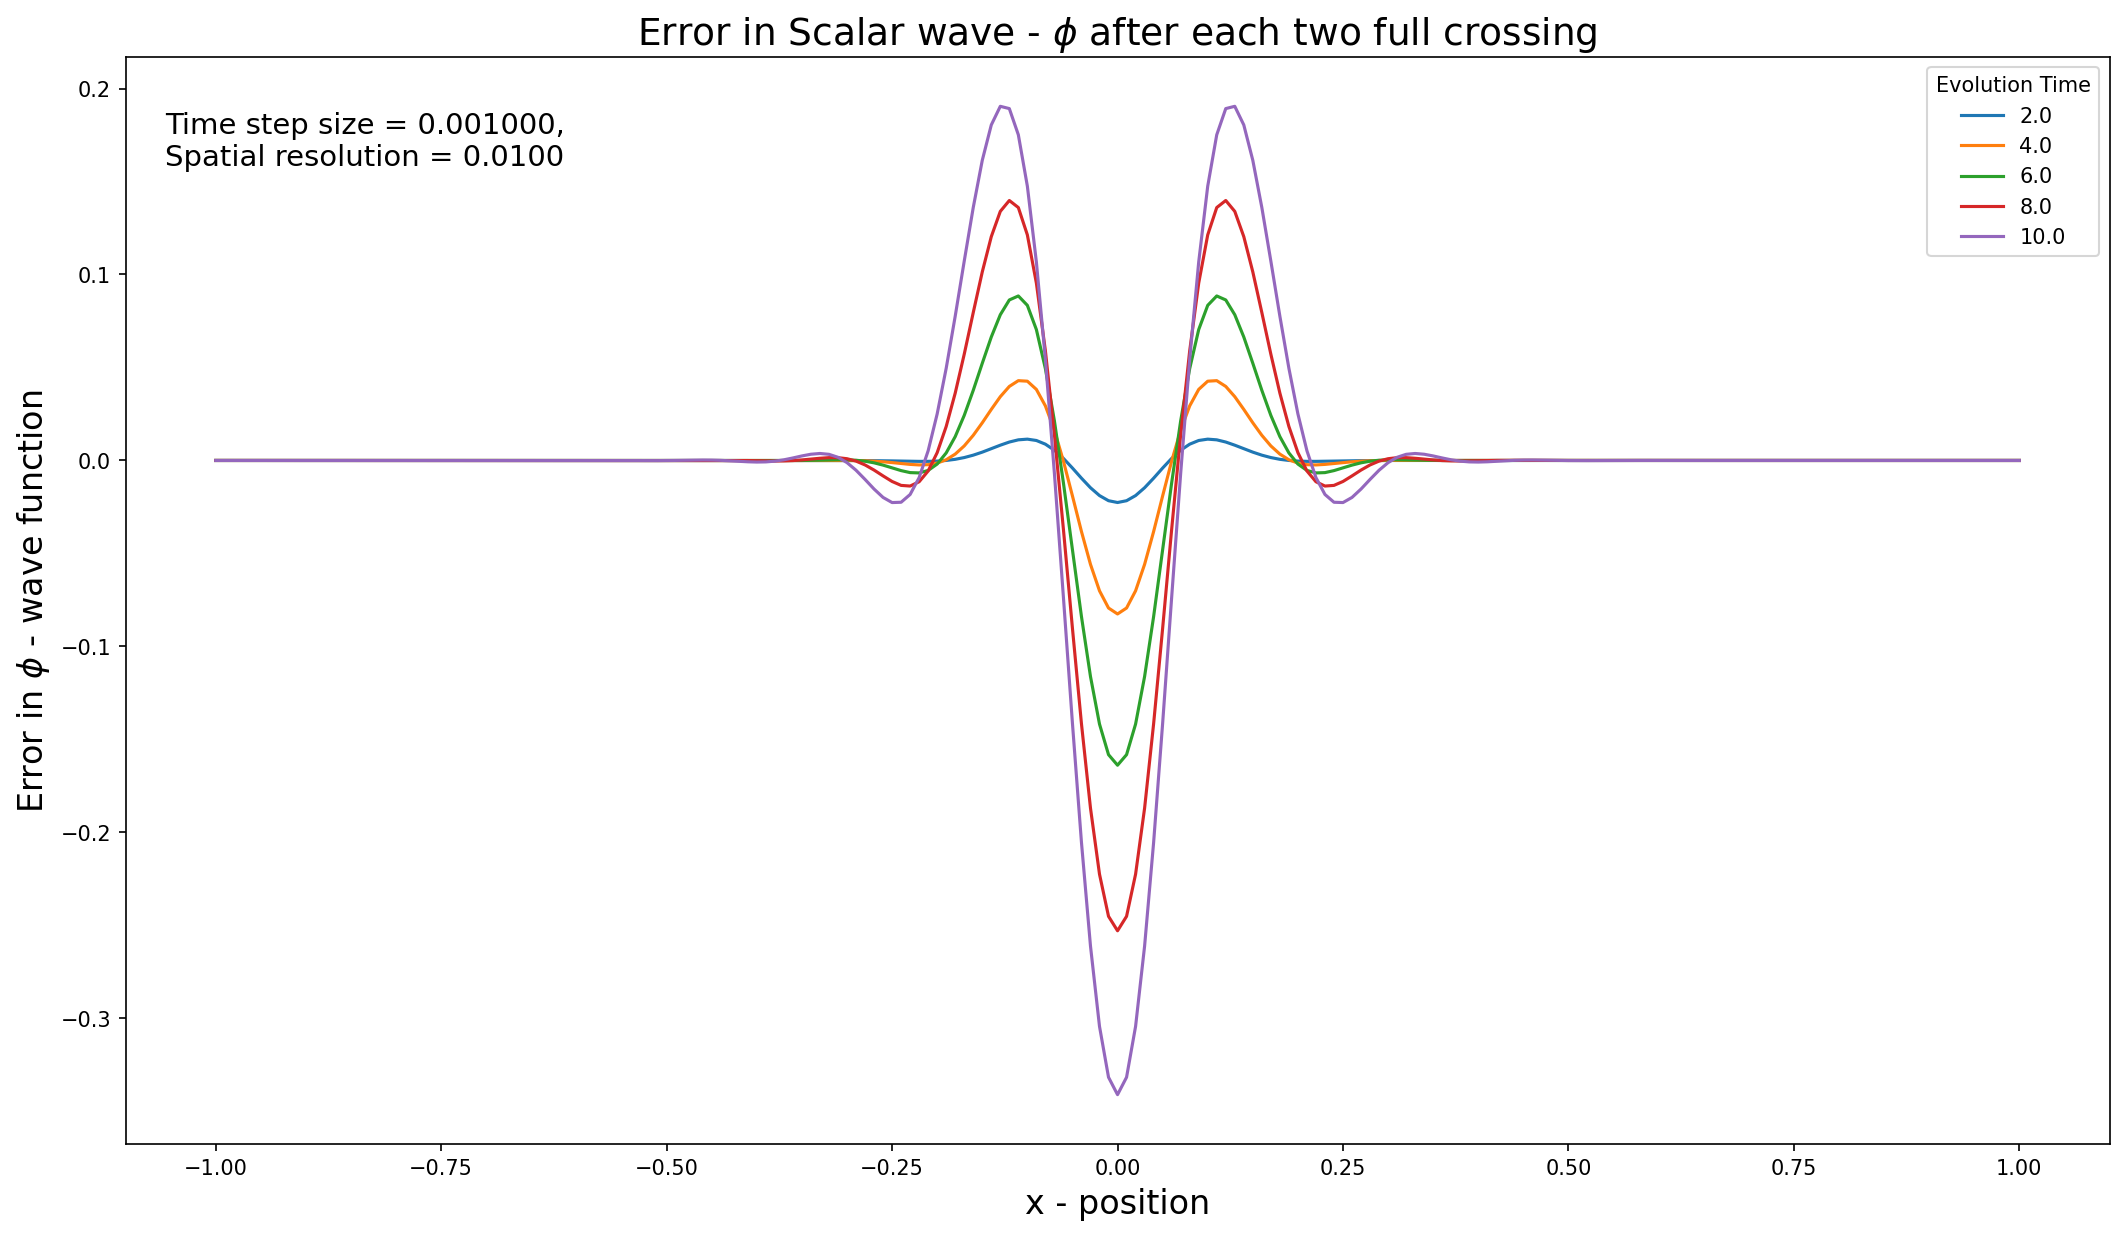

In [19]:
var_x = np.arange(x_start,x_end + dx,dx)
def plots(title,x_label,y_label,x_param,y_param):
    fig_dpi = 150
    fig, ax = plt.subplots(figsize=(2560/fig_dpi,1440/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=18)
    plt.xlabel(x_label,fontsize=16)
    plt.ylabel(y_label,fontsize=16)
    plt.plot(x_param,y_param,label="crossing times")
    plt.legend(crossing_times,title="Evolution Time",loc='upper right')
    plt.text(0.02, 0.90, 'Time step size = %.6f,\nSpatial resolution = %.4f'%(dt,dx),
             transform=ax.transAxes,fontsize=14)
    plt.show()

plots(r'Error in Scalar wave - $\phi$ after each two full crossing',
      "x - position",r'Error in $\phi$ - wave function',
      var_x,np.transpose(error))

In [20]:
def plots(title,x_label,y_label,x_param,y_param,i):
    fig_dpi = 100
    fig, ax = plt.subplots(figsize=(1280/fig_dpi,720/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=10)
    plt.ylabel(y_label,fontsize=10)
    ax.axis([-1.1,+1.1,-1.5,1.5])
    plt.plot(x_param,y_param)
    plt.text(0.02, 0.95, 'Time = %.4f'%var_t[i], transform=ax.transAxes)
    plt.show()

0


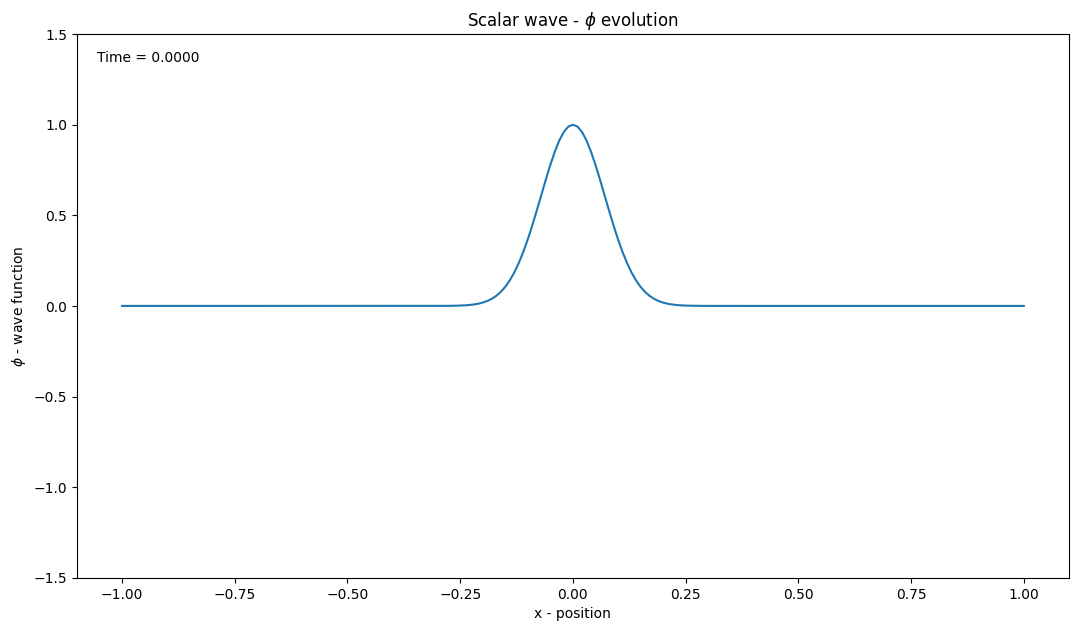

2000


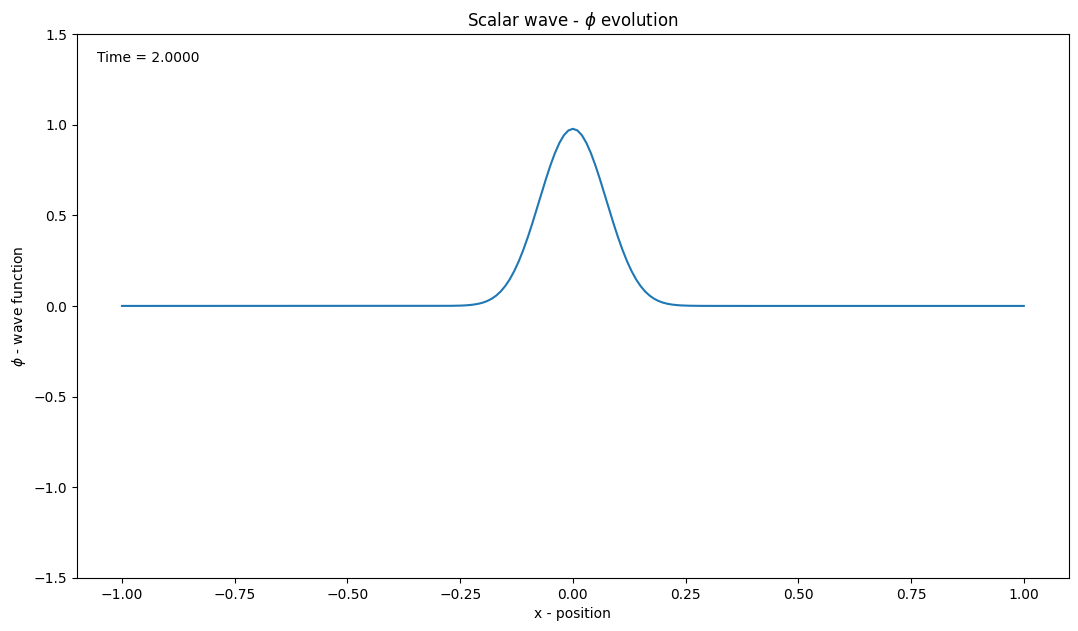

4000


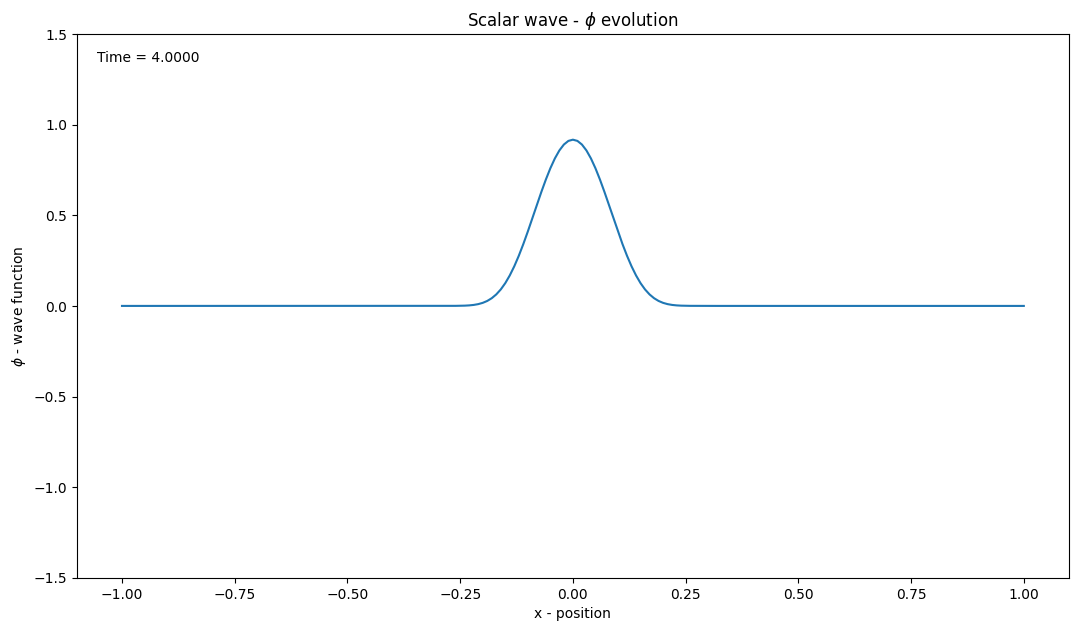

6000


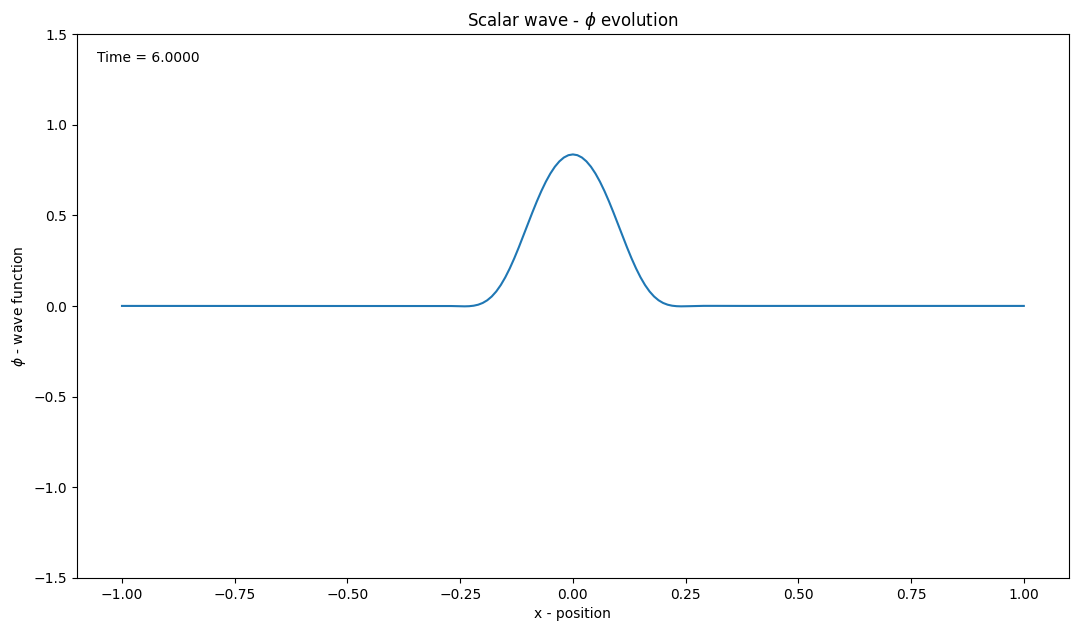

8000


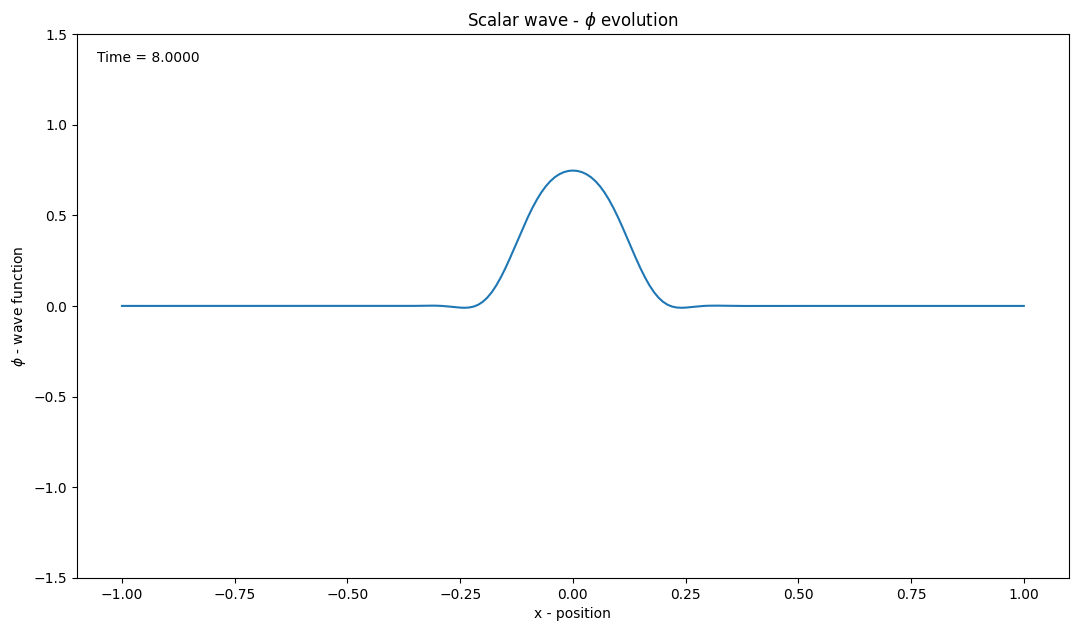

10000


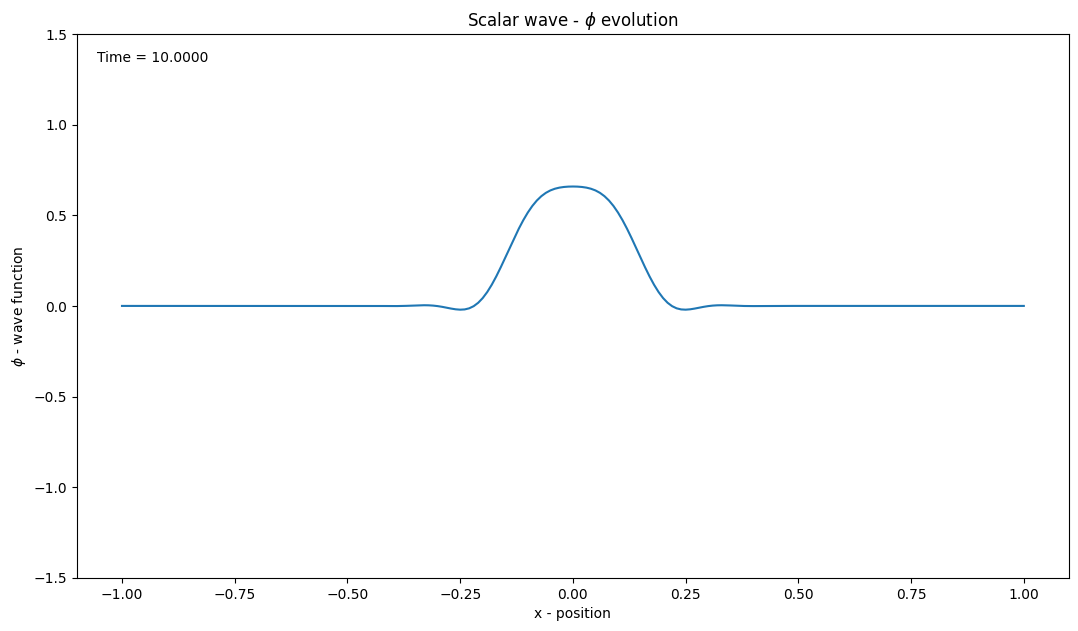

In [21]:
for i in range (0,len(var_t),two_full_crossing_iter):
    print(i)
    plots(r'Scalar wave - $\phi$ evolution',"x - position",r'$\phi$ - wave function',
          var_x,phi_result[i,:],i)

In [22]:
# # Produce frames to render movie

# import multiprocessing

# def plots(pl):
#     ii = pl[0]
#     fc = pl[1]
#     fig_dpi = 100
#     fig, ax = plt.subplots(figsize=(640/fig_dpi,480/fig_dpi),dpi = fig_dpi)
#     plt.title(r'Scalar wave - $\phi$ evolution',fontsize=12)
#     plt.xlabel("x - position",fontsize=10)
#     plt.ylabel(r'$\phi$ - wave function',fontsize=10)
#     ax.axis([-1.1,+1.1,-1.5,1.5])
#     plt.plot(var_x,phi_result[ii])
#     plt.text(0.02, 0.95, 'Time = %.4f'%var_t[ii], transform=ax.transAxes)
#     plt.savefig("plots_tmp/plot%05d.png"%fc)
#     plt.close(fig)
    
# iter_v = np.arange(0,len(var_t),10) #produce frame every 10 iterations
# frame_count = np.arange(0,len(iter_v),1)
# pl = np.zeros((len(frame_count),2),dtype=int)
# pl[:,0] = iter_v
# pl[:,1] = frame_count
# print("Total number of frames to be rendered: %d"%len(frame_count))

# # multiprocessing to render frames
# pool = multiprocessing.Pool(processes=2) #total 4 procs, 8 threads
# %time pool_return = pool.map(plots,pl)

In [23]:
# Test for energy conservation

phi_result = np.zeros((Nx,Nt))
phi_dot_result = np.zeros((Nx,Nt))
phi_prime_result = np.zeros((Nx,Nt))
energy_density = np.zeros((Nx,Nt))
phi_result = u_result[:,0]
phi_dot_result = u_result[:,1]
phi_prime_result = np.transpose(phi_prime_result)
energy_density = np.transpose(energy_density)

In [24]:
# phi_prime -> first order derivative w.r.t 'x' to be computed

def first_order_derivative(var,dx):
    D1_var = np.zeros(Nx)
    var_with_ghosts = compute_exterior_points(var)
    for i in range (1,len(var_with_ghosts)-1):
        # Central finite difference method:
        D1_var[i-1] = (var_with_ghosts[i+1] - var_with_ghosts[i-1])/(2*dx)
    return D1_var

for i in range (Nt):
    phi_prime_result[i] = first_order_derivative(phi_result[i],dx)

In [25]:
# Calculate total energy -> 1/2*phi_dot^2 + 1/2*phi_prime^2

for i in range (Nt):
    energy_density[i] = 1/2*( (phi_dot_result[i])**2 + (phi_prime_result[i])**2 )

In [26]:
# idx = [0,Nx-1]
# concat_total_energy = np.zeros((Nx-Nghost,Nt))
# concat_total_energy = np.transpose(concat_total_energy)
# concat_var_x = np.zeros(Nx-Nghost)
# concat_var_x = np.delete(var_x,idx)
# for i in range (Nt):
#     concat_total_energy[i] = np.delete(total_energy[i],idx)

In [27]:
# Calculate energy density -> integrate Energy function along x-axis
def integrate_simpson(h,param_y): #Ref: https://atozmath.com/example/CONM/NumeInte.aspx?he=e&q=S13
    t1,t2 = 0,0
    for i in range (1,len(param_y)-1): 
        if (i%2 == 1): #odd integers
            t1 = t1 + param_y[i]
            #print("t1[i]",i)
        #print(t1)
        if (i%2 == 0) : #even integers
            t2 = t2 + param_y[i]
            #print("t2[i]",i)
        #print(t2)
    integral = (h/3)*(param_y[0] + 4*t1 + 2*t2 + param_y[len(param_y)-1] )
    return integral
total_energy = np.zeros(Nt)
for i in range (Nt):
    total_energy[i] = integrate_simpson(dx,energy_density[i])

<function matplotlib.pyplot.show(close=None, block=None)>

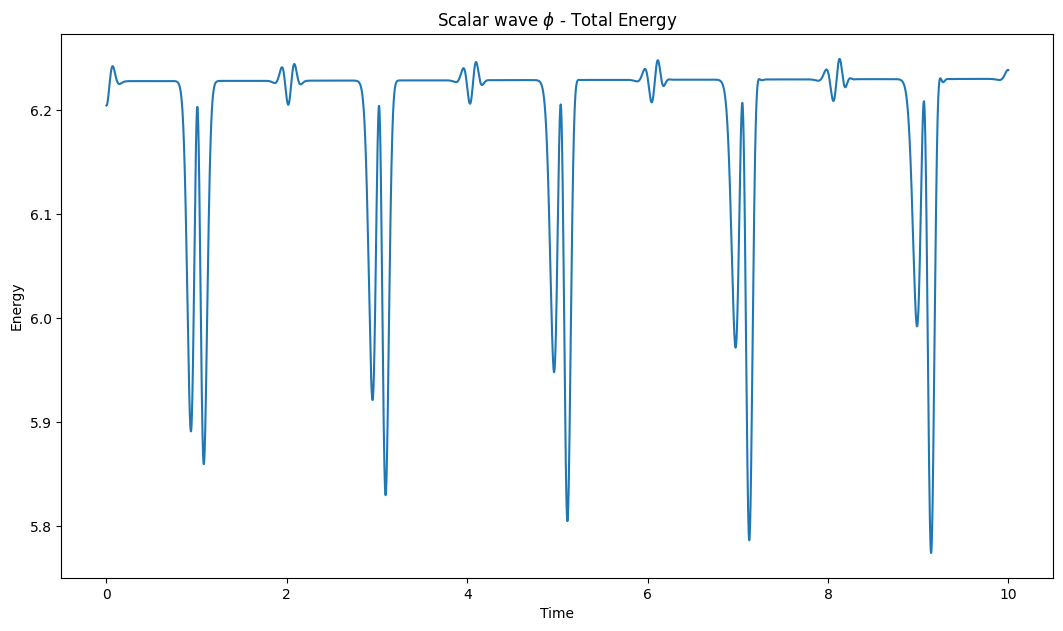

In [34]:
fig_dpi = 100
fig, ax = plt.subplots(figsize=(1280/fig_dpi,720/fig_dpi),dpi = fig_dpi)
plt.title(r'Scalar wave $\phi$ - Total Energy',fontsize=12)
plt.xlabel("Time",fontsize=10)
plt.ylabel('Energy',fontsize=10)
#ax.axis([-1.1,+1.1,-100,100])
#plt.xlim(0,10)
plt.plot(var_t,total_energy)
plt.show

In [29]:
def plots2(title,x_label,y_label,x_param,y_param,i):
    fig_dpi = 100
    fig, ax = plt.subplots(figsize=(1280/fig_dpi,720/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=10)
    plt.ylabel(y_label,fontsize=10)
    ax.axis([-1.1,+1.1,-100,100])
    plt.plot(x_param,y_param)
    plt.text(0.02, 0.95, 'Time = %.4f'%var_t[i], transform=ax.transAxes)
    plt.show()

0


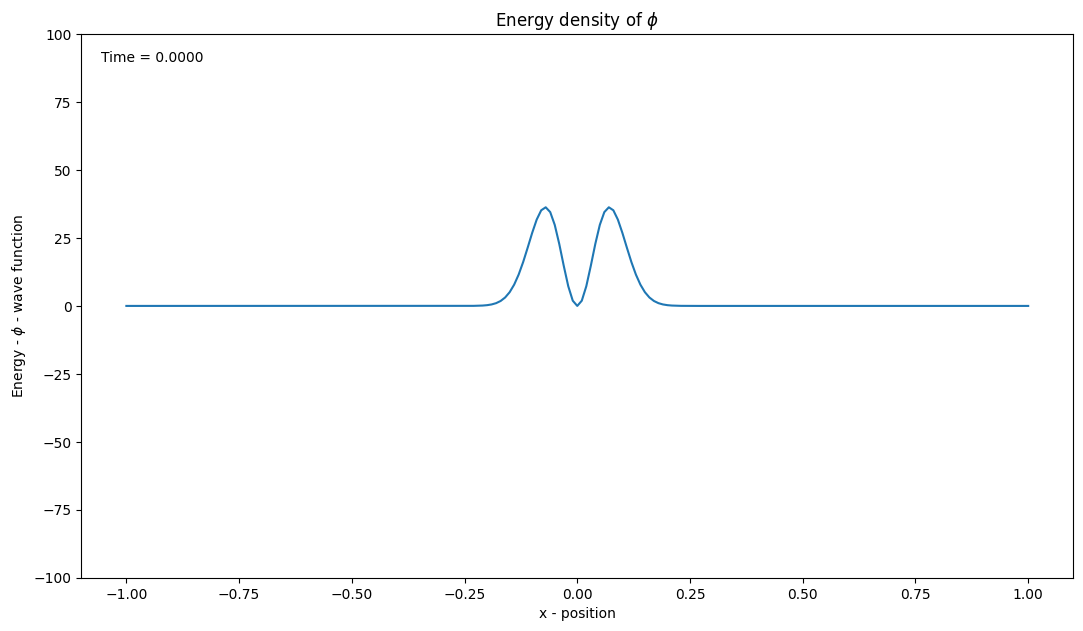

1000


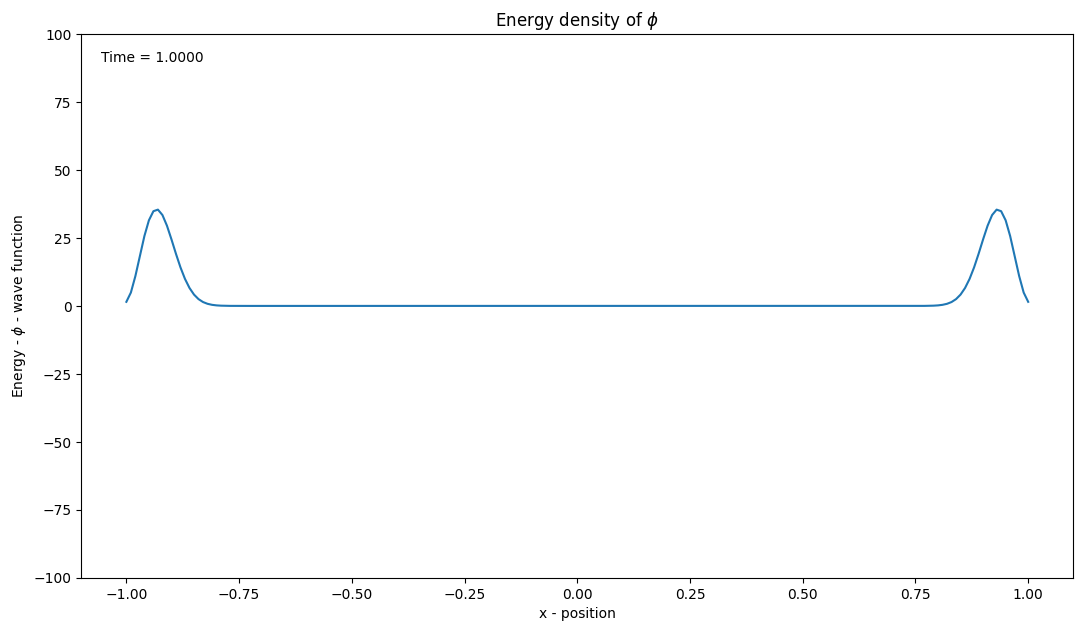

2000


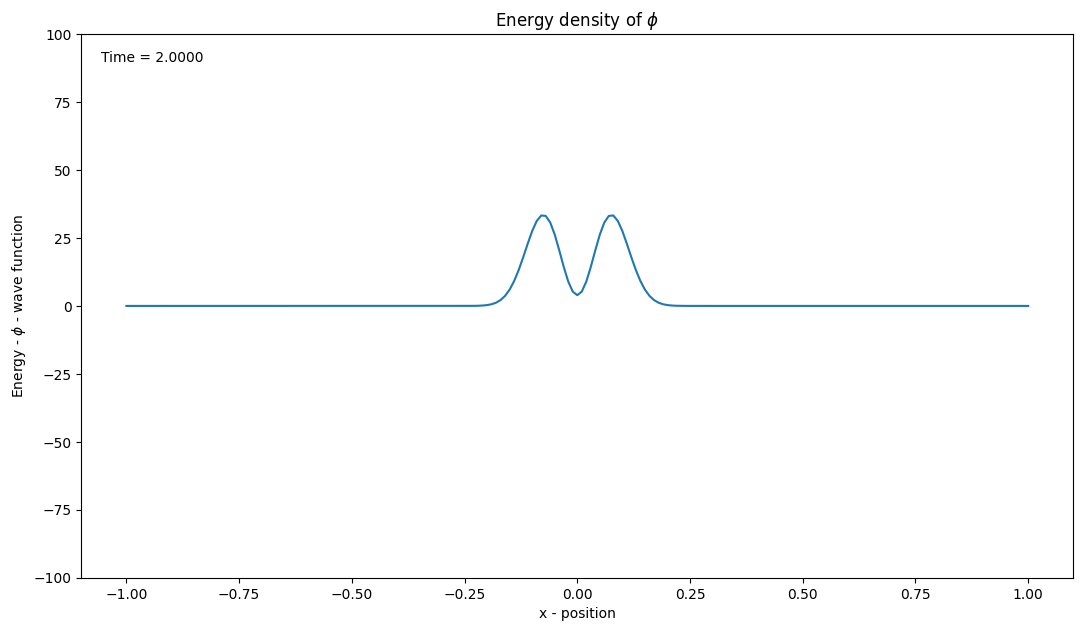

3000


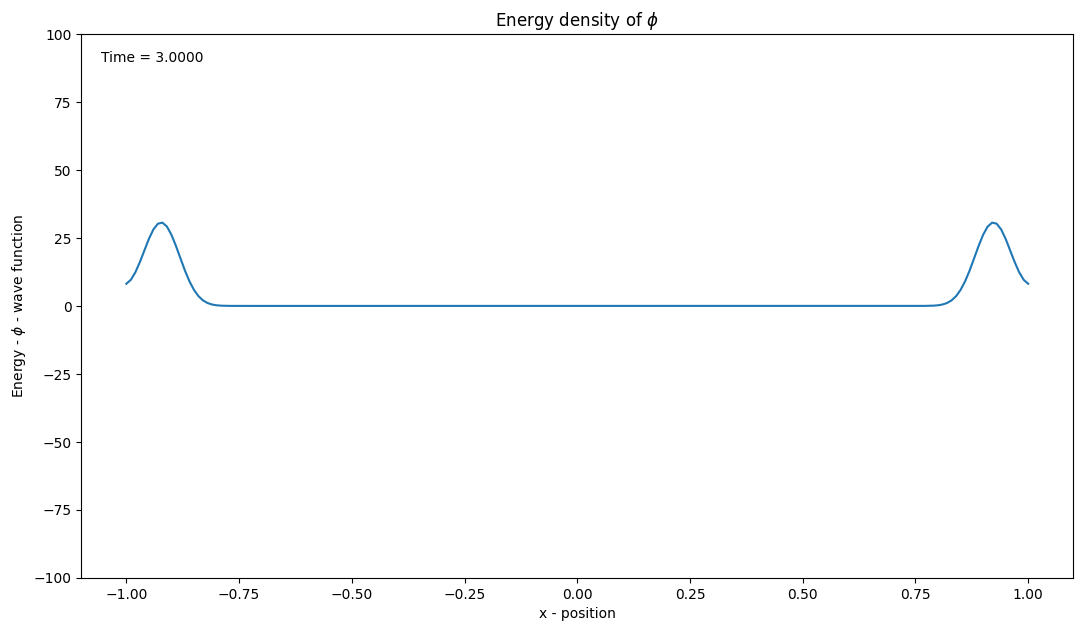

4000


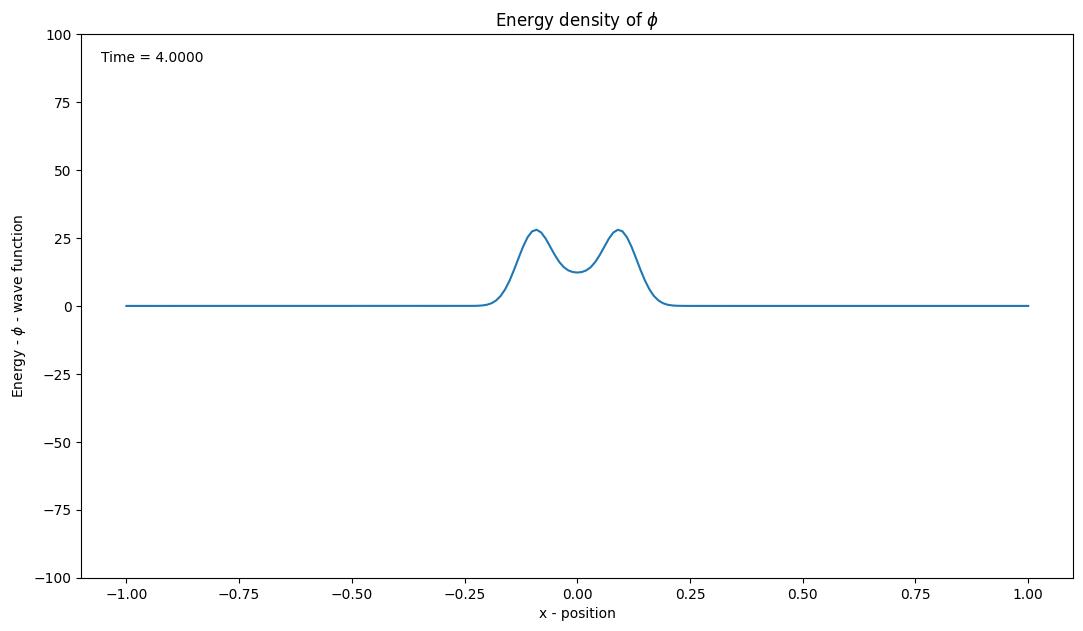

5000


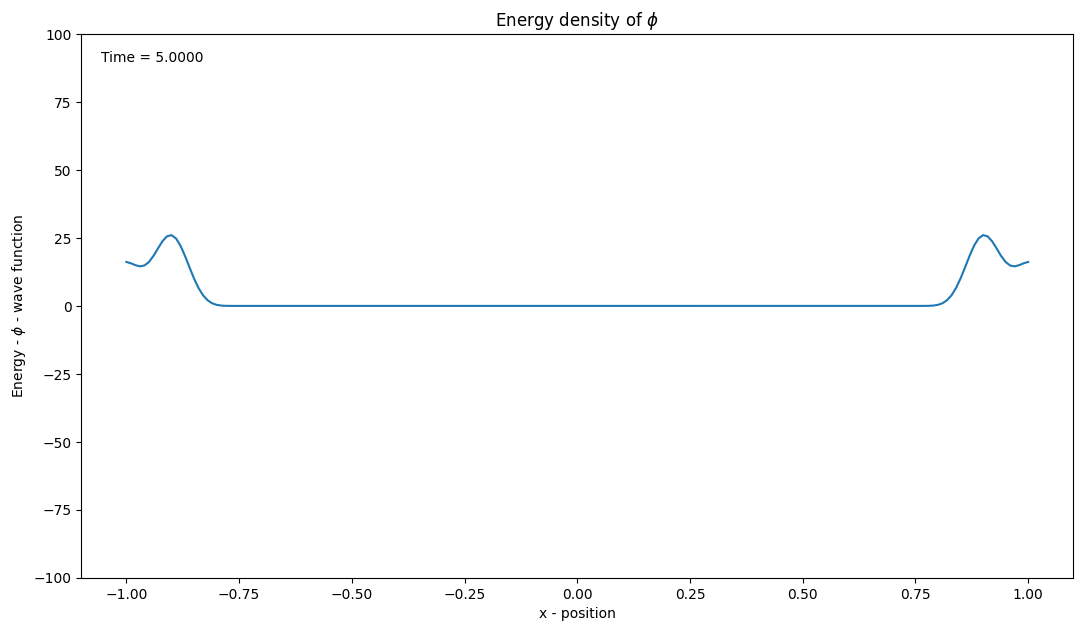

6000


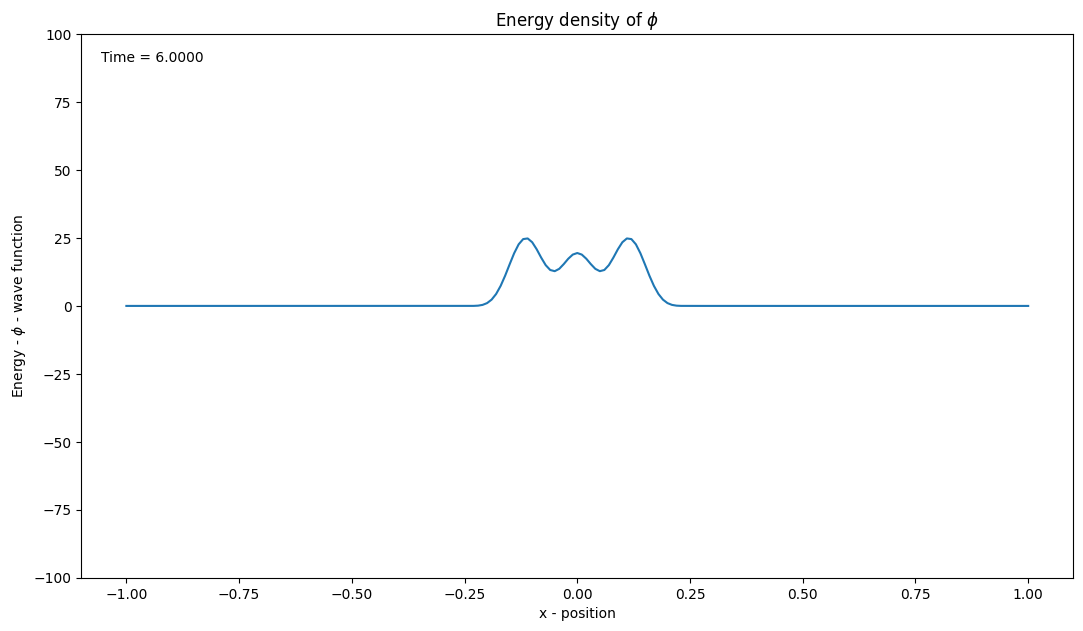

7000


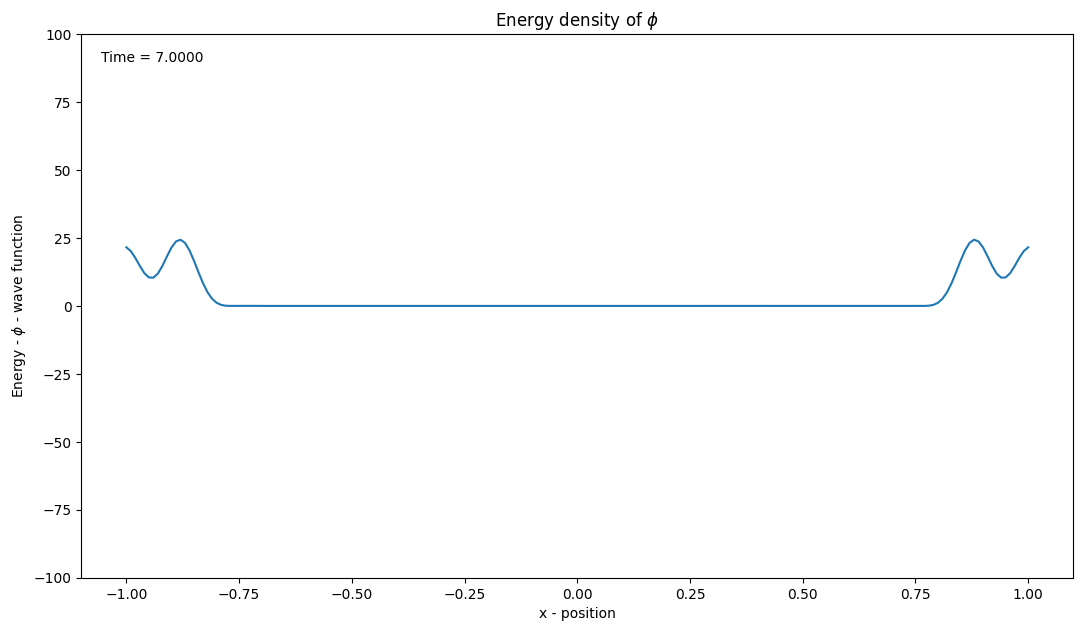

8000


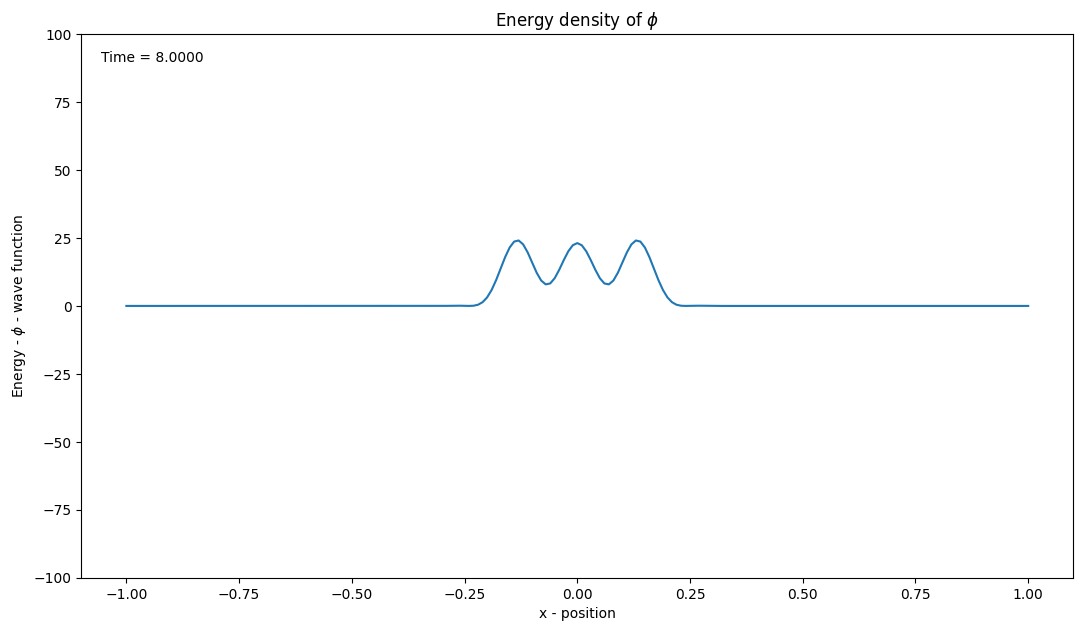

9000


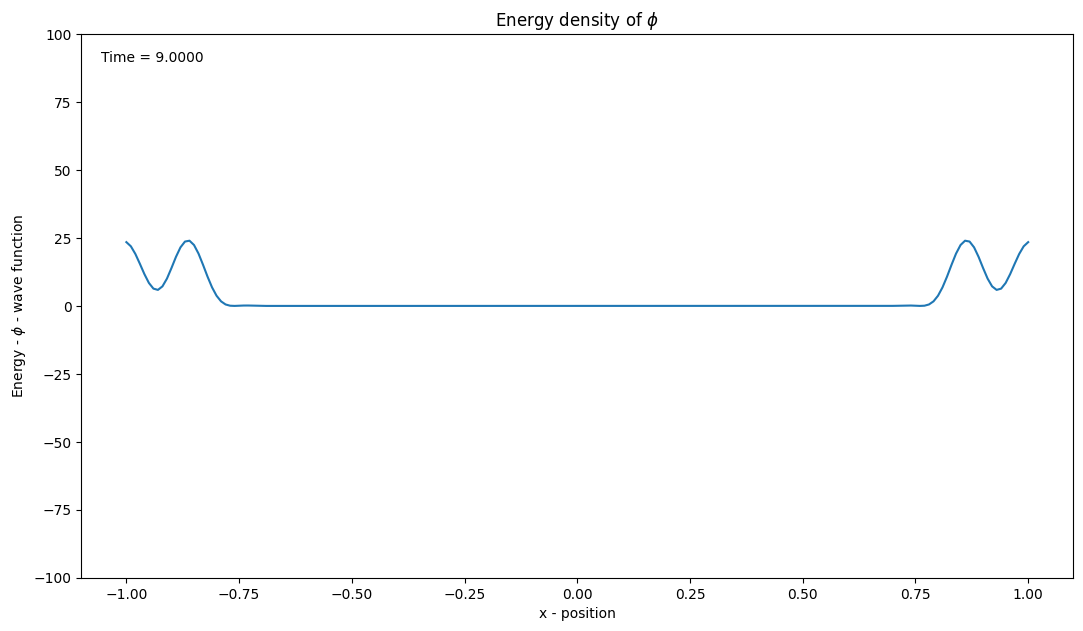

10000


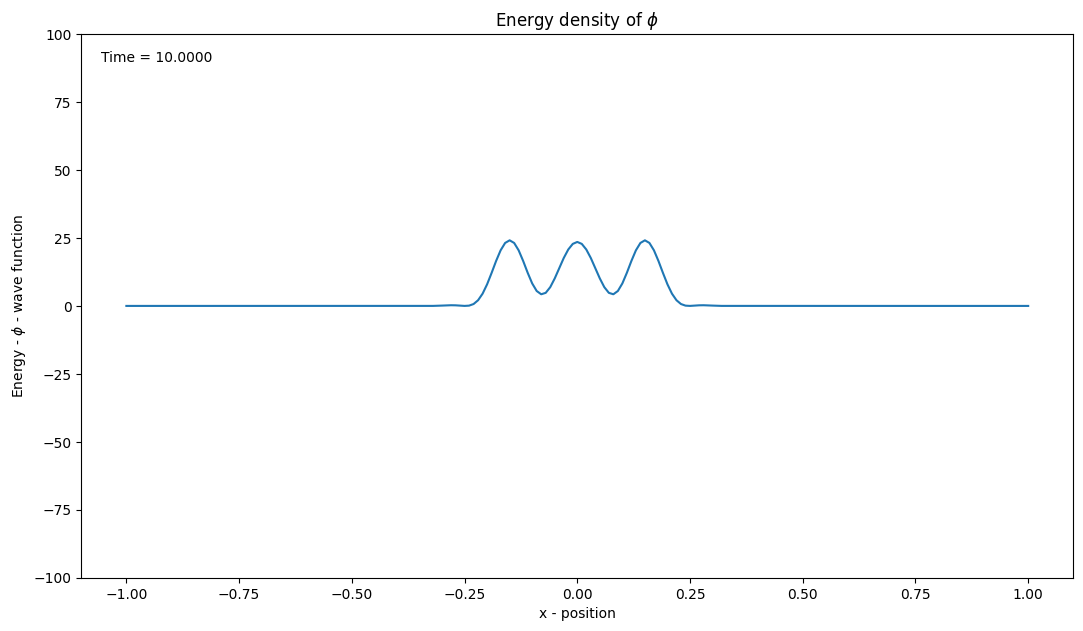

In [32]:
for i in range (0,Nt,1000):
    print(i)
    plots2(r"Energy density of $\phi$ ","x - position",r'Energy - $\phi$ - wave function',
          var_x,energy_density[i],i)